# Step-Index Fibre

Procedure for calculating the propagation constants of a graded-index fibre.

### 1. The Scalar Wave Equation

The analysis begins with the time-independent scalar wave equation, which is a valid approximation for weakly guiding fibers where the refractive index contrast between the core and cladding is small. The equation for a monochromatic electric field $E$ is:

$$ \nabla^2 E + k_0^2 n(r)^2 E = 0 $$

Here:
- $k_0 = 2\pi / \lambda_0$ is the free-space wavenumber, with $\lambda_0 = 633 \text{ nm}$.
- $n(r)$ is the radially-dependent refractive index profile of the fiber.

In cylindrical coordinates $(r, \phi, z)$, the Laplacian operator is $\nabla^2 = \frac{\partial^2}{\partial r^2} + \frac{1}{r}\frac{\partial}{\partial r} + \frac{1}{r^2}\frac{\partial^2}{\partial \phi^2} + \frac{\partial^2}{\partial z^2}$.

### 2. Separation of Variables

We assume a solution that is separable in its coordinates, representing a mode propagating along the fiber's z-axis:

$$ E(r, \phi, z) = \psi(r) e^{jl\phi} e^{-j\beta z} $$

- $\psi(r)$ is the radial mode profile.
- $l$ is the integer azimuthal mode number. The provided code focuses on **meridional modes**, for which $l=0$.
- $\beta$ is the longitudinal propagation constant, which we aim to find.

Substituting this solution into the wave equation and simplifying yields the ordinary differential equation for the radial profile $\psi(r)$:

$$ \left[ \frac{d^2}{dr^2} + \frac{1}{r}\frac{d}{dr} - \frac{l^2}{r^2} \right] \psi(r) + \left( k_0^2 n(r)^2 - \beta^2 \right) \psi(r) = 0 $$

For meridional modes ($l=0$), this simplifies to:

$$ \left[ \frac{d^2}{dr^2} + \frac{1}{r}\frac{d}{dr} \right] \psi(r) + k_0^2 n(r)^2 \psi(r) = \beta^2 \psi(r) $$

This is a Sturm-Liouville eigenvalue problem of the form $\hat{O}\psi = \lambda\psi$, where $\hat{O} = \left[\nabla_r^2 + k_0^2 n(r)^2\right]$ is an operator, $\psi(r)$ are the eigenfunctions (mode profiles), and $\lambda = \beta^2$ are the eigenvalues.

### 3. Numerical Solution via the Hankel Transform

To solve this equation numerically, we discretize the problem and represent the differential operator as a matrix. The code uses the Hankel transform, which is a natural choice for problems with cylindrical symmetry.

The key property of the order-zero Hankel transform ($\mathcal{H}_0$) is its effect on the radial Laplacian operator $\nabla_r^2 = \frac{d^2}{dr^2} + \frac{1}{r}\frac{d}{dr}$:

$$ \mathcal{H}_0 \left\{ \nabla_r^2 \psi(r) \right\} = -k_r^2 \cdot \mathcal{H}_0 \left\{ \psi(r) \right\} $$

where $k_r$ is the radial spatial frequency, the conjugate variable to the radial coordinate $r$.

The procedure is as follows:
1.  **Transform to Frequency Domain**: The field profile $\psi(r)$ is transformed into the spatial frequency domain using a forward Hankel transform.
2.  **Apply Laplacian**: In the frequency domain, the complex differential operator $\nabla_r^2$ becomes a simple multiplication by $-k_r^2$.
3.  **Transform Back to Spatial Domain**: The result is transformed back to the spatial domain using a backward (inverse) Hankel transform.

In the provided code, this is implemented using matrix operations. The radial coordinate `r` and frequency `kr` are discretized into vectors.
- A forward Hankel transform matrix, `hf`, converts the vector `psi` from real space to frequency space.
- A backward Hankel transform matrix, `hb`, performs the inverse operation.

The matrix representation of the Laplacian operator, $\mathbf{L}_r$, is therefore constructed as:

$$ \mathbf{L}_r = \mathbf{hb} \cdot \text{diag}(-k_r^2) \cdot \mathbf{hf} $$

This corresponds to the code line: `hb @ (-col(h.kr**2) * hf)`.

### 4. Constructing the Eigenvalue Problem

The continuous radial equation can now be written as a discrete matrix eigenvalue equation:

$$ \left( \mathbf{L}_r + \text{diag}(k_0^2 n(r)^2) \right) \psi = \beta^2 \psi $$

The matrix `D` in the code is the discrete representation of the operator on the left-hand side:

$$ \mathbf{D} = \mathbf{hb} \cdot \text{diag}(-k_r^2) \cdot \mathbf{hf} + \text{diag}(k_0^2 n(r)^2) $$

The `scipy.linalg.eig(D)` function solves this problem, returning:
- `beta2`: A list of eigenvalues, corresponding to $\beta^2$.
- `psi`: A matrix whose columns are the corresponding eigenvectors, representing the discretized radial mode profiles $\psi(r)$.

Finally, the code filters for **guided modes**. A mode is guided if its propagation constant $\beta$ is bounded by the wavenumbers of the cladding and the core:

$$ k_0 n_{\text{clad}} < \beta < k_0 n_0 $$

This is equivalent to the condition `(beta2 > (k0*n_clad)**2) & (beta2 < (k0*n0)**2)`, which selects the physically meaningful solutions.

The refractive index profile $n(r)$ used in the code is:
$$ n(r)^2 = \begin{cases} n_0^2 (1 - 2\Delta(r/a)^8) & r \le a \\ n_{\text{clad}}^2 & r > a \end{cases} $$
where $a$ is the core radius and $\Delta \approx (n_0 - n_{\text{clad}})/n_0$.

In [1]:
from typing import Self
import numpy as np
from numpy.typing import NDArray
from scipy import special, linalg
from matplotlib import pyplot as plt

PI = np.pi
TAU = 2*PI

## Functions

In [2]:
# Convert data to a row vector: size=(1,N)
def row(x: NDArray) -> NDArray:
    return x.reshape((1, -1))


# Convert data to a column vector: size=(N, 1)
def col(x: NDArray) -> NDArray:
    return x.reshape((-1, 1))

# Refractive index of bulk fused silica (SiO2) - Malitson (1965)
def ref_index_fused_silica(l_um: NDArray) -> NDArray:
    return np.sqrt(
        1
        + 0.6961663 / (1 - (0.0684043 / l_um) ** 2)
        + 0.4079426 / (1 - (0.1162414 / l_um) ** 2)
        + 0.8974794 / (1 - (9.896161 / l_um) ** 2)
    )


class HT:
    """ Generate quasi-discrete Hankel Transform Matrix
    The algorithm used is that from:
        "Computation of quasi-discrete Hankel transforms of the integer order for propagating optical wave fields"
        Manuel Guizar-Sicairos and Julio C. Guitierrez-Vega
        J. Opt. Soc. Am. A 21(1) 53-58 (2004)
    """
    def __init__(self: Self, rmax: float, samples: int, order: int = 0):
        assert rmax > 0, "Maximum radius must be positive"
        assert (
            samples.is_integer() and samples > 0
        ), "Number of samples must be a positive integer"
        assert (
            order.is_integer() and order >= 0
        ), "Order must be an integer greater or equal than zero"
        self.rmax = rmax
        self.samples = samples
        self.order = order
        self.update()

    def update(self: Self):
        roots = special.jn_zeros(self.order, self.samples + 1)
        self.roots = roots[:-1]
        self.S = roots[-1].item()
        self.K = self.S / self.rmax
        self.V = self.K / TAU

        self.r = self.roots * self.rmax / self.S
        self.kr = self.roots / self.rmax
        self.v = self.kr / TAU

        Jn = special.jn(self.order, self.roots[:, np.newaxis] * self.roots / self.S)
        Jn1 = abs(special.jn(self.order + 1, self.roots))
        self.T = 2 * Jn / (Jn1[:, np.newaxis] * Jn1 * self.S)
        self.Jn1 = Jn1
        self.JV = Jn1 / self.V
        self.JR = Jn1 / self.rmax
        self.Trk = (self.JV.reshape((-1, 1)) / self.JR) * self.T
        self.Tkr = (self.JR.reshape((-1, 1)) / self.JV) * self.T

    def tofreq(self: Self, fr):
        N = fr.shape
        fr = fr.reshape((N[0], -1))
        JR = self.JR.reshape((-1, 1))
        JV = self.JV.reshape((-1, 1))
        return (JV * np.matmul(self.T, (fr / JR))).reshape(N)

    def tospace(self: Self, fk):
        N = fk.shape
        fk = fk.reshape((N[0], -1))
        JR = self.JR.reshape((-1, 1))
        JV = self.JV.reshape((-1, 1))
        return (JR * np.matmul(self.T, (fk / JV))).reshape(N)


## Define Fibre Parameters

In [3]:
l0 = 633e-3 # Wavelength [um]
k0 = TAU/l0
a = 5 # Fibre radius [um]
NA_eff = 0.2 # Effective numerical aperture

n_clad = ref_index_fused_silica(l0).item() # Ref. index of cladding #type:ignore
# n_clad = 1.457
n0 = np.sqrt(NA_eff**2 + n_clad**2).item() # Ref. index of "core"
delta = .5*(NA_eff/n0)**2

In [4]:
# Define maximum angle and radial co-ordinates
kr_max = k0*NA_eff
r_max = 5*a

# Determine number of samples: j_{l,n+1} ~ r_max * kr_max
j0 = special.jn_zeros(0, 1<<8)
while j0[-1]<kr_max*r_max:
    j0 = special.jn_zeros(0, 2*len(j0))

Nr = int(10*sum(j0<=kr_max*r_max)) # Number of radial samples, with padding
h = HT(r_max, Nr, 0)
# h = HT(r_max, 1<<8, 0)

# Define forward and backwards Hankel transform matrices
hf = col(h.JV) * h.T / row(h.JR)
hb = col(h.JR) * h.T / row(h.JV)

# Define cladding and "core" regions
ind_core = (h.r<=a)
ind_clad = ~ind_core

In [5]:
n_core2 = n0**2 * (1 - 2*delta*(h.r/a)**2)
nr2 = ind_clad * n_clad**2 + ind_core * n0**2*(1 - 2*delta*(h.r/a)**8)
D = hb @ (-col(h.kr**2) * hf) + np.diag(k0**2*nr2)

beta2, psi = linalg.eig(D) # type:ignore
beta2 = np.real(beta2)
ind = (beta2>(k0*n_clad)**2) & (beta2<(k0*n0)**2)
beta = np.sqrt(beta2[ind])
psi = psi[:, ind]
print(f"{n_clad = }", f"{n0 = }", f"{k0*n_clad = }", f"{k0*n0 = }", "\nbeta [rad/um]", np.round(beta, 4), sep="\n")


n_clad = 1.4570121246412515
n0 = 1.4706747877595556
k0*n_clad = 14.462365203678393
k0*n0 = 14.59798138718846

beta [rad/um]
[14.5883 14.5513 14.4956]


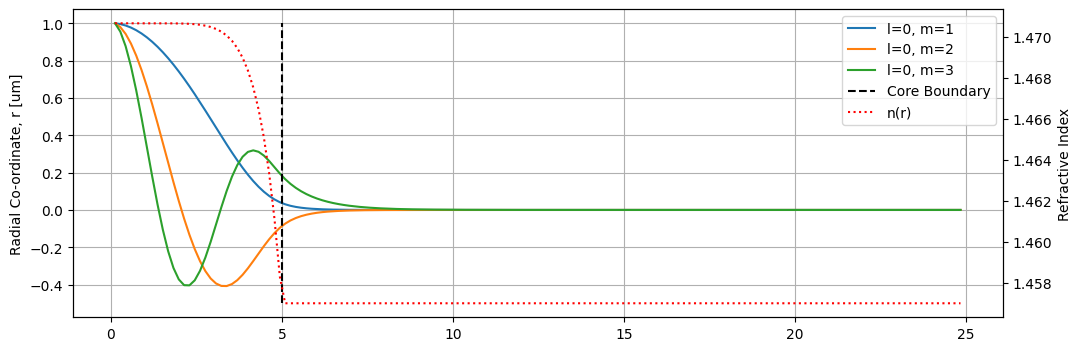

In [6]:
fig, ax = plt.subplots(figsize=(12, 4))
h1 = ax.plot(h.r, psi/psi[0])
h1.append(ax.plot([a]*2, [-.5, 1], "k--")[0])
ax.grid()
ax.set_ylabel("Mode Amplitude")
ax.set_ylabel("Radial Co-ordinate, r [um]")

ax1 = ax.twinx()
h1.append(ax1.plot(h.r, np.sqrt(nr2), "r:")[0])
ax1.set_ylabel("Refractive Index")

ax.legend(h1, [f"l=0, m={m+1}" for m in range(len(beta))] + ["Core Boundary", "n(r)"])

plt.show()